In [0]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import numpy as np
import random
from gensim.models import word2vec
from gensim.models import Word2Vec
import time
nltk.download('wordnet')
nltk.download('WordNetLemmatizer')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
!pip install modelsummary
# model summary
from modelsummary import summary

# this is for filtering the warnings
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(9)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Error loading WordNetLemmatizer: Package
[nltk_data]     'WordNetLemmatizer' not found in index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for modelsummary: filename=modelsummary-1.1.7-cp36-none-any.whl size=6955 sha256=d5c3cbb338d1222037a77349df758cc6f890953aee3d55a37dcec32a3fbc449a
  Stored in directory: /root/.cache/pip/wheels/fc/d3/e8/1ed6d9523b8480be97ccded9ecfed3413e84c73dae12bcc329
Successfully built modelsummary


# 1.  Preprocessing

数据预处理部分大概需要做：

1. 读取数据
2. 使用gensim.word2vec训练词向量，建立词向量映射
3. sentenses to idx list

In [0]:
# gdrive
from google.colab import drive  as gdrive
gdrive.mount('/content/drive')
!cp /content/drive/My\ Drive/ml2020spring-hw4.zip ./data.zip
!unzip data.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  data.zip
  inflating: testing_data.txt        
  inflating: training_label.txt      
  inflating: training_nolabel.txt    


In [0]:
# google
# !gdown --id '1lz0Wtwxsh5YCPdqQ3E3l_nbfJT1N13V8' --output data.zip
# !unzip data.zip
# !ls

In [0]:
# local

## 1.1 文本预处理

读取句子，对文本进行一些预处理。

- **分词**，对于英文来说，分词只需要用空格，标点进行即可，给定数据中已经给标点前后增加空格。
- **删除停用词** ，例如to，for等，这在文本处理中是可选项，这些词存在与否对于部分任务，例如文本分类，但在例如机器翻译中，就不进行。至于需不需要保留标点符号，我认为应该差不多。一方面，考虑标点符号和上下文关系不大，因而word2vec可能没有什么意义，但标点符号有利于句子的划分。所以这里不对标点符号进行处理。
- **词型还原**，同样是可选项，英文中词有多种时态，但是word2vec中却会分为多个词，这显然是不太合理的，对于文本情感分析，直觉上，时态并不会给文本分类带来太多什么帮助。

ref https://panchuang.net/2019/08/31/nlp-essentials-removing-stopwords-and-performing-text-normalization-using-nltk-and-spacy-in-python/

更新：
事实证明，删除停用词，词型还原都没有用，尤其是删除停用词会对结果产生负影响。


In [0]:
def load_data(data_path, name):
    y = None
    # read
    with open(os.path.join(data_path, name)) as f:
        sentenses = f.readlines()
        if name == 'testing_data.txt':
            sentenses = sentenses[1:]
            sentenses = [sen.split(',',1)[1] for sen in sentenses]
        if name == 'training_label.txt':
            y = [int(sen[0]) for sen in sentenses]
            sentenses = [sen[10:] for sen in sentenses]
            
        sentences = [sen.strip('\n').split() for sen in sentenses]
    # deal with stopword and tense
    
    def lemmatize(word):
        wnl = WordNetLemmatizer()
        word = wnl.lemmatize(word, 'n')
        word = wnl.lemmatize(word, 'v')
        word = wnl.lemmatize(word, 'a')
        return word

    x = []
    stopword = set(stopwords.words('english'))
    # # without stopword and lemmatize
    x = [sen.split() for sen in sentenses]
    # lemmatize
    # for sentence in sentences:
    #     x.append([lemmatize(word) for word in sentence])    

    # stopword  & lemmatize
    # for sentence in sentences:
    #     x.append([lemmatize(word) for word in sentence if word not in stopword])
    
    if y:
        return x,y
    else:
        return x

In [0]:

data_path = './'
train_data,train_label = load_data(data_path, 'training_label.txt')
print('====train data')
print('size: {}'.format(len(train_data)))
print(train_data[:10])
print(train_label[:10])

====train data
size: 200000
[['are', 'wtf', '...', 'awww', 'thanks', '!'], ['leavingg', 'to', 'wait', 'for', 'kaysie', 'to', 'arrive', 'myspacin', 'itt', 'for', 'now', 'ilmmthek', '.!'], ['i', 'wish', 'i', 'could', 'go', 'and', 'see', 'duffy', 'when', 'she', 'comes', 'to', 'mamaia', 'romania', '.'], ['i', 'know', 'eep', '!', 'i', 'can', "'", 't', 'wait', 'for', 'one', 'more', 'day', '....'], ['so', 'scared', 'and', 'feeling', 'sick', '.', 'fuck', '!', 'hope', 'someone', 'at', 'hr', 'help', '...', 'wish', 'it', 'would', 'be', 'wendita', 'or', 'karen', '.'], ['my', 'b', 'day', 'was', 'thurs', '.', 'i', 'wanted', '2', 'do', '5', 'this', 'weekend', 'for', 'my', 'b', 'day', 'but', 'i', 'guess', 'close', 'enough', 'next', 'weekend', '.', 'going', 'alone'], ['e3', 'is', 'in', 'the', 'trending', 'topics', 'only', 'just', 'noticed', 'ive', 'been', 'tweeting', 'on', 'my', 'iphone', 'until', 'now'], ['where', 'did', 'you', 'get', 'him', 'from', 'i', 'know', 'someone', 'who', 'would', 'love', 'tha

In [0]:
# test_data = load_data(data_path, 'testing_data.txt')
# print('====test data')
# print('size: {}'.format(len(test_data)))
# print(test_data[:10])
# train_nolabel = load_data(data_path, 'training_nolabel.txt')
# print('====train data without label')
# print('size: {}'.format(len(train_nolabel)))
# print(train_nolabel[:10])

## 1.2 word2vec

- 训练词向量，单层神经网络预测下一个词，取hidden layer的输出，以此向量化。把所有数据拿出来训练词向量。gensim.word2vec已经写好了框架，直接使用训练。
- 建立word2idx，idx2vec的映射。
- 然后将sentenses转为indies list



In [0]:
emb_dim = 250
# model = word2vec.Word2Vec(train_data+test_data+train_nolabel,
#                           size = emb_dim,                                                                 # dimension
#                           window = 5,                                                              # windlow of context
#                           min_count = 5,                                                          # remove low frequency word
#                           workers = 12,                                                            # precess tread 
#                           iter = 10,                                                                   # iteration
#                           sg = 1                                                                       #  if 1, use skp-gram, 0 use cbow
#                           )

In [0]:
wv_name = 'w2v_all_without'
# wv_name = 'w2v_all_lem'
# wv_name = 'w2v_all'
# model.save(os.path.join(data_path, wv_name))
# !mkdir /content/drive/My\ Drive/hw4/
# !cp  w2v_all*  /content/drive/My\ Drive/hw4/

In [0]:
# load word2vec model
!cp /content/drive/My\ Drive/hw4/w2v_all* ./
w2v_path = os.path.join(data_path, wv_name)
w2v_model = Word2Vec.load(w2v_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# map word to idx, idx to vector
word2idx = {}
idx2word = []
embedding_matrix = []
print(w2v_model['wtf'].shape)
for word in w2v_model.wv.vocab:
    idx2word.append(word)
    word2idx[word] = len(idx2word)-1
    embedding_matrix.append(w2v_model[word])

# add <PAD> and <UNK> 
word  = '<PAD>'
idx2word.append(word)
word2idx[word] = len(idx2word)-1
embedding_matrix.append(np.random.uniform(0,1,emb_dim))
word  = '<UNK>'
idx2word.append(word)
word2idx[word] = len(idx2word)-1
embedding_matrix.append(np.random.uniform(0,1,emb_dim))

# embedding_matrix = np.concatenate(embedding_matrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(250,)


In [0]:
emb_matrix = np.zeros((len(embedding_matrix), emb_dim))
for i in range(emb_matrix.shape[0]):
    emb_matrix[i, :] = embedding_matrix[i][:]

sentense to ldx list 需要规整句子长度，查看长度分布，定义长度。

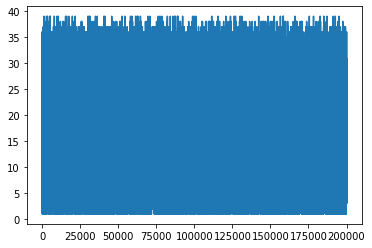

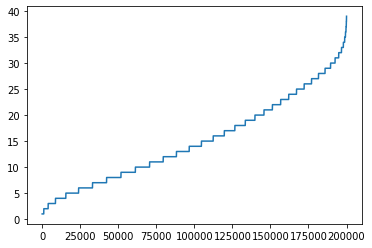

In [0]:
from matplotlib import pyplot as plt
def show_ditribution(data):
    '''
    show data ditribution
    '''
    n = len(data)
    plt.plot(range(n),data)
    plt.show()
    plt.plot(range(n),np.sort(data))
    plt.show()

show_ditribution([len(sen) for sen in train_data])

In [0]:
len_sentence = 20
def data_preprocess(train_data, train_label = None, word2idx = None, len_sentence = 20):
    train_x = np.empty((len(train_data), len_sentence))
    
    for i,sentence in enumerate(train_data):
            sen_len = len(sentence)
            for j in range(len_sentence):
                if j >= sen_len:
                    train_x[i,j] = word2idx['<PAD>']
                    continue
                word = sentence[j]
                if word in word2idx.keys():
                    train_x[i,j] = word2idx[word]
                else:
                    train_x[i,j] = word2idx['<UNK>']
    
    # print("==train_x")
    # print(train_x[:10])
    # print("size: {}".format(train_x.shape))
    # print(train_y[:10])

    if train_label is not None:
        train_y = np.array(train_label)
        return train_x, train_y
    else:
        return train_x


In [0]:
train_x, train_y = data_preprocess(train_data, train_label, word2idx, 20)
val_x = train_x[18000:]
val_y = train_y[18000:]
train_x = train_x[:18000]
train_y = train_y[:18000]

## 1.3 Extend Dataset

In [0]:
from torch.utils import data
class Dataset(data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    def __getitem__(self, i):
        # if self.y is not None:
        #     return torch.LongTensor(self.x[i, :]), torch.LongTensor(self.y[i])
        # return torch.LongTensor(self.x[i, :])
        if self.y is not None:
            return self.x[i, :], self.y[i]
        return self.x[i, :]
    def __len__(self):
        return len(self.x)

In [0]:
batch_size = 128
train_set = Dataset(train_x, train_y)
val_set = Dataset(val_x, val_y)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 2. Model

构建模型，主要是embedding层注意一下即可。

另外，pytorch里的LSTM参数很多，尤其是输入，输出，理解起来比较难。

````python
Inputs: input, (h_0, c_0)
    input of shape (seq_len, batch, input_size)
    h_0 of shape (num_layers * num_directions, batch, hidden_size)
    c_0 of shape (num_layers * num_directions, batch, hidden_size)
Outputs: output, (h_n, c_n)
    output of shape (seq_len, batch, num_directions * hidden_size)
    h_n of shape (num_layers * num_directions, batch, hidden_size)
    c_n of shape (num_layers * num_directions, batch, hidden_size)
````
结合这个图，按照batch_first理解，即input为（batch, 序列长, 输入维度），忽略batch，都视为1个sample。所以输入是一个矩形（序列长度，输入维度），输出是一个矩形（序列长度，输出维度）。如果是双向，则输出维度x2.

然后是c，h，c和h的维度是一致的，为单个LSTM单元的输出，pytorch可以指定初始c，h，得到所有输出c，h。同样，batch_first，忽略batch，则每个LSTM单元的输出为（输出维度），n层LSTM输出维度为（层数，输出维度），所以同样都是矩形。

输入如果不指定c_0，h_0则默认为0.
![](https://pic4.zhimg.com/80/v2-ebf8cd2faa564d9d80a958dcf25e6b3b_720w.jpg)



In [0]:
import torch.nn as nn
import torch

In [0]:

class lstm_model(nn.Module):
    def __init__(self, embedding_matrix, trainable_embedding = False):
        super(lstm_model,self).__init__()
        self.dim_emb =  embedding_matrix.shape[1]
        self.embedding = nn.Embedding(embedding_matrix.shape[0], self.dim_emb )
        self.embedding.weight = nn.Parameter(torch.Tensor(embedding_matrix))
        self.embedding.weight.requires_grad = trainable_embedding
        self.lstm_layers = nn.LSTM(self.dim_emb, 256, num_layers = 1, batch_first = True)
        self.dnn = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256, 1),
                        nn.Sigmoid()
        )
    def forward(self, x):
        out = self.embedding(x)
        out,_ = self.lstm_layers(out)
        out = out[:, -1, :] # 输出默认为sequence，使用最后一个time step的输出, (none，output_dim)，不需要再flatten
        return self.dnn(out)
        

# 3. Training

````python
for epoch
    for x_batch in train_data
        # forward
        pred_batch <- model.predict(x_batch)
        loss_batch <- loss_function(pred_batch, y_batch)

        # backward
        optim: gradient descent

        # record log
        acc += calculate batch acc (pred_batch, y_batch)
        loss += loss_batch

    calculate val loss & acc
````

In [0]:
import time
import torch

In [0]:
def cal_acc(pred_b, y_b):
    output_b = pred_b.cpu().detach().numpy().reshape(-1)
    output_b[output_b>=0.5] = 1
    output_b[output_b < 0.5] = 0
    output_b = output_b.astype(np.int32)
    return np.sum(output_b == y_b.numpy())

learning_rate = 0.001
num_epoch = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = './'

model = lstm_model(emb_matrix).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
loss_func = nn.BCELoss()
logs = {'time':[], 'train_loss':[], 'train_acc':[], 'val_acc':[], 'val_loss':[]}
best_epochs = []
best_acc = 0
for epoch in range(num_epoch):
    time_epoch_start = time.time()
    train_acc = 0.0 
    train_loss = 0.0
    model.train()
    for i, (x_b, y_b) in enumerate(train_loader):
        # forward
        optimizer.zero_grad() 
        pred_b = model(x_b.to(device, dtype = torch.long)) # torch的特点，需要将数据设置到gpu上
        loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float))
        # backward
        loss_b.backward()
        optimizer.step()
        # log
        train_acc += cal_acc(pred_b, y_b)
        train_loss += loss_b.item()
   # calculate val acc and loss
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i,(x_b, y_b) in enumerate(val_loader):
            pred_b = model(x_b.to(device, dtype = torch.long))
            loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float))
            val_acc += cal_acc(pred_b, y_b)
            val_loss += loss_b.item()
    # print log
    logs['time'].append(time.time()-time_epoch_start)
    logs['train_acc'].append(train_acc/train_set.__len__())
    logs['train_loss'].append(train_loss/train_set.__len__())
    logs['val_acc'].append(val_acc/val_set.__len__())
    logs['val_loss'].append(val_loss/val_set.__len__()) 
    
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch,  logs['time'][-1], \
            logs['train_acc'][-1] , logs['train_loss'][-1], logs['val_acc'][-1], logs['val_loss'][-1])) 
    # save best model
    # notes： early stop
    if val_acc > best_acc:
        best_acc = val_acc
        best_epochs.append(epoch)
        torch.save(model, os.path.join(path, 'best.model'))
        print("Saving with acc : {}".format(logs['val_acc'][-1]))
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[001/020] 6.11 sec(s) Train Acc: 0.601222 Loss: 0.005044 | Val Acc: 0.751066 loss: 0.003998
Saving with acc : 0.751065934065934


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type lstm_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[002/020] 6.69 sec(s) Train Acc: 0.756222 Loss: 0.003872 | Val Acc: 0.774412 loss: 0.003691
Saving with acc : 0.7744120879120879
[003/020] 6.07 sec(s) Train Acc: 0.780500 Loss: 0.003606 | Val Acc: 0.776824 loss: 0.003635
Saving with acc : 0.7768241758241758
[004/020] 5.91 sec(s) Train Acc: 0.789444 Loss: 0.003485 | Val Acc: 0.779835 loss: 0.003686
Saving with acc : 0.7798351648351648
[005/020] 6.46 sec(s) Train Acc: 0.798278 Loss: 0.003357 | Val Acc: 0.779379 loss: 0.003596
[006/020] 6.39 sec(s) Train Acc: 0.803667 Loss: 0.003301 | Val Acc: 0.783863 loss: 0.003565
Saving with acc : 0.7838626373626374
[007/020] 5.88 sec(s) Train Acc: 0.812278 Loss: 0.003157 | Val Acc: 0.781104 loss: 0.003619
[008/020] 5.90 sec(s) Train Acc: 0.825278 Loss: 0.003007 | Val Acc: 0.778819 loss: 0.003711
[009/020] 6.54 sec(s) Train Acc: 0.834556 Loss: 0.002854 | Val Acc: 0.775390 loss: 0.003870
[010/020] 6.54 sec(s) Train Acc: 0.849000 Loss: 0.002622 | Val Acc: 0.770659 loss: 0.003931
[011/020] 6.64 sec(s) Tr

In [0]:
train_data[0]

['are', 'wtf', '...', 'awww', 'thanks', '!']

无处理数据
````
[001/020] 6.22 sec(s) Train Acc: 0.577111 Loss: 0.005176 | Val Acc: 0.733516 loss: 0.004225
Saving with acc : 0.0042251411809043566
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type lstm_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
[002/020] 6.19 sec(s) Train Acc: 0.753889 Loss: 0.003981 | Val Acc: 0.763495 loss: 0.003845
Saving with acc : 0.0038445410171707908
[003/020] 6.18 sec(s) Train Acc: 0.774389 Loss: 0.003722 | Val Acc: 0.771890 loss: 0.003742
Saving with acc : 0.0037423860882664774
[004/020] 5.99 sec(s) Train Acc: 0.782167 Loss: 0.003582 | Val Acc: 0.747500 loss: 0.003972
[005/020] 6.39 sec(s) Train Acc: 0.792333 Loss: 0.003466 | Val Acc: 0.779396 loss: 0.003628
Saving with acc : 0.0036276583070610907
[006/020] 6.38 sec(s) Train Acc: 0.802000 Loss: 0.003323 | Val Acc: 0.780951 loss: 0.003628
Saving with acc : 0.003627572279546287
[007/020] 6.30 sec(s) Train Acc: 0.811000 Loss: 0.003176 | Val Acc: 0.779802 loss: 0.003663
[008/020] 6.25 sec(s) Train Acc: 0.820722 Loss: 0.003040 | Val Acc: 0.774808 loss: 0.003727
[009/020] 6.09 sec(s) Train Acc: 0.830444 Loss: 0.002881 | Val Acc: 0.769989 loss: 0.003840
[010/020] 6.28 sec(s) Train Acc: 0.849500 Loss: 0.002680 | Val Acc: 0.771621 loss: 0.003905
[011/020] 6.60 sec(s) Train Acc: 0.864167 Loss: 0.002425 | Val Acc: 0.762593 loss: 0.004190
[012/020] 5.92 sec(s) Train Acc: 0.880000 Loss: 0.002164 | Val Acc: 0.763824 loss: 0.004621
[013/020] 6.35 sec(s) Train Acc: 0.901944 Loss: 0.001845 | Val Acc: 0.746473 loss: 0.005116
[014/020] 5.91 sec(s) Train Acc: 0.919111 Loss: 0.001557 | Val Acc: 0.748291 loss: 0.005405
[015/020] 6.34 sec(s) Train Acc: 0.934056 Loss: 0.001287 | Val Acc: 0.751000 loss: 0.006179
[016/020] 6.33 sec(s) Train Acc: 0.952944 Loss: 0.001006 | Val Acc: 0.750341 loss: 0.006643
[017/020] 6.10 sec(s) Train Acc: 0.961333 Loss: 0.000828 | Val Acc: 0.743890 loss: 0.007536
[018/020] 6.02 sec(s) Train Acc: 0.967444 Loss: 0.000696 | Val Acc: 0.740676 loss: 0.008257
[019/020] 5.97 sec(s) Train Acc: 0.978833 Loss: 0.000493 | Val Acc: 0.739808 loss: 0.008277
[020/020] 6.48 sec(s) Train Acc: 0.985944 Loss: 0.000345 | Val Acc: 0.741335 loss: 0.009711
````
stopword and lemmatize

````
[002/020] 6.56 sec(s) Train Acc: 0.524556 Loss: 0.005401 | Val Acc: 0.500648 loss: 0.005383
Saving with acc : 0.5006483516483516
[003/020] 6.61 sec(s) Train Acc: 0.519611 Loss: 0.005416 | Val Acc: 0.514505 loss: 0.005399
Saving with acc : 0.5145054945054945
[004/020] 6.78 sec(s) Train Acc: 0.510944 Loss: 0.005426 | Val Acc: 0.513533 loss: 0.005419
[005/020] 6.62 sec(s) Train Acc: 0.521333 Loss: 0.005421 | Val Acc: 0.514093 loss: 0.005400
[006/020] 6.45 sec(s) Train Acc: 0.621667 Loss: 0.005070 | Val Acc: 0.708319 loss: 0.004523
Saving with acc : 0.7083186813186814
[007/020] 6.61 sec(s) Train Acc: 0.732889 Loss: 0.004248 | Val Acc: 0.747973 loss: 0.004009
Saving with acc : 0.7479725274725275
[008/020] 6.65 sec(s) Train Acc: 0.755611 Loss: 0.003969 | Val Acc: 0.756632 loss: 0.003949
Saving with acc : 0.7566318681318681
[009/020] 6.09 sec(s) Train Acc: 0.765944 Loss: 0.003807 | Val Acc: 0.761170 loss: 0.003840
Saving with acc : 0.7611703296703297
[010/020] 6.04 sec(s) Train Acc: 0.776500 Loss: 0.003702 | Val Acc: 0.757418 loss: 0.003863
[011/020] 5.88 sec(s) Train Acc: 0.782000 Loss: 0.003625 | Val Acc: 0.762725 loss: 0.003822
Saving with acc : 0.7627252747252747
[012/020] 6.76 sec(s) Train Acc: 0.786111 Loss: 0.003564 | Val Acc: 0.759060 loss: 0.003862
[013/020] 5.98 sec(s) Train Acc: 0.795500 Loss: 0.003448 | Val Acc: 0.753214 loss: 0.003969
[014/020] 6.51 sec(s) Train Acc: 0.806056 Loss: 0.003327 | Val Acc: 0.759709 loss: 0.004027
[015/020] 5.98 sec(s) Train Acc: 0.817278 Loss: 0.003174 | Val Acc: 0.754099 loss: 0.004141
[016/020] 6.78 sec(s) Train Acc: 0.827889 Loss: 0.003053 | Val Acc: 0.740198 loss: 0.004076
[017/020] 6.24 sec(s) Train Acc: 0.840889 Loss: 0.002830 | Val Acc: 0.738308 loss: 0.004236
[018/020] 6.69 sec(s) Train Acc: 0.859667 Loss: 0.002600 | Val Acc: 0.740049 loss: 0.004642
[019/020] 6.24 sec(s) Train Acc: 0.878056 Loss: 0.002363 | Val Acc: 0.728973 loss: 0.005339
[020/020] 6.60 sec(s) Train Acc: 0.894278 Loss: 0.002109 | Val Acc: 0.736577 loss: 0.005142
````

only lematize

````
[002/020] 6.20 sec(s) Train Acc: 0.744833 Loss: 0.004122 | Val Acc: 0.762291 loss: 0.003953
Saving with acc : 0.7622912087912088
[003/020] 6.31 sec(s) Train Acc: 0.767500 Loss: 0.003845 | Val Acc: 0.769253 loss: 0.003753
Saving with acc : 0.7692527472527473
[004/020] 5.88 sec(s) Train Acc: 0.780278 Loss: 0.003646 | Val Acc: 0.773319 loss: 0.003708
Saving with acc : 0.7733186813186813
[005/020] 5.96 sec(s) Train Acc: 0.786500 Loss: 0.003551 | Val Acc: 0.773879 loss: 0.003673
Saving with acc : 0.7738791208791209
[006/020] 6.68 sec(s) Train Acc: 0.795833 Loss: 0.003400 | Val Acc: 0.771484 loss: 0.003692
[007/020] 6.02 sec(s) Train Acc: 0.804778 Loss: 0.003307 | Val Acc: 0.775912 loss: 0.003695
Saving with acc : 0.7759120879120879
[008/020] 5.94 sec(s) Train Acc: 0.812889 Loss: 0.003190 | Val Acc: 0.778346 loss: 0.003694
Saving with acc : 0.7783461538461538
[009/020] 6.66 sec(s) Train Acc: 0.826389 Loss: 0.003014 | Val Acc: 0.771022 loss: 0.004065
[010/020] 6.08 sec(s) Train Acc: 0.838667 Loss: 0.002835 | Val Acc: 0.771835 loss: 0.004120
[011/020] 5.93 sec(s) Train Acc: 0.852278 Loss: 0.002624 | Val Acc: 0.756467 loss: 0.004178
[012/020] 6.31 sec(s) Train Acc: 0.874167 Loss: 0.002345 | Val Acc: 0.759115 loss: 0.004357
[013/020] 5.94 sec(s) Train Acc: 0.889667 Loss: 0.002035 | Val Acc: 0.760368 loss: 0.004817
[014/020] 5.84 sec(s) Train Acc: 0.910444 Loss: 0.001735 | Val Acc: 0.756863 loss: 0.005646
[015/020] 6.32 sec(s) Train Acc: 0.925667 Loss: 0.001460 | Val Acc: 0.746308 loss: 0.005780
[016/020] 6.52 sec(s) Train Acc: 0.944111 Loss: 0.001153 | Val Acc: 0.741687 loss: 0.006552
[017/020] 6.51 sec(s) Train Acc: 0.953556 Loss: 0.001004 | Val Acc: 0.745615 loss: 0.007161
[018/020] 5.85 sec(s) Train Acc: 0.963333 Loss: 0.000794 | Val Acc: 0.744615 loss: 0.007531
[019/020] 6.67 sec(s) Train Acc: 0.973389 Loss: 0.000588 | Val Acc: 0.744181 loss: 0.008812
[020/020] 6.36 sec(s) Train Acc: 0.978778 Loss: 0.000494 | Val Acc: 0.737962 loss: 0.009193
````

In [0]:
# notes：打印参数，summary
!pip install modelsummary
from modelsummary import summary
summary(lstm_model(emb_matrix), torch.zeros((20,20), dtype = torch.long))
sum_ = 0

for p,n in zip(model.parameters(), model.state_dict()):
    print(n, '||', p.numel())

-----------------------------------------------------------------------
             Layer (type)                Input Shape         Param #
              Embedding-1                   [-1, 20]      13,944,500
                    GRU-2              [-1, 20, 250]               0
                Dropout-3                  [-1, 256]               0
                 Linear-4                  [-1, 256]             257
                Sigmoid-5                    [-1, 1]               0
Total params: 13,944,757
Trainable params: 257
Non-trainable params: 13,944,500
-----------------------------------------------------------------------
13944500
192000
196608
768
768
256
1
14334901


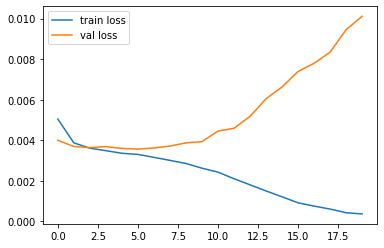

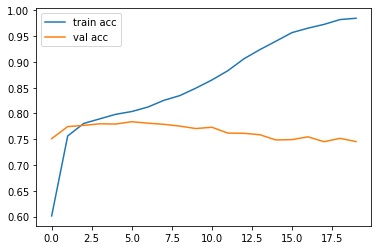

In [0]:
# 平滑函数
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

from matplotlib import pyplot as plt
smooth_factor = 0
plt.plot(logs['train_loss'], label = 'train loss')
plt.plot(smooth_curve(logs['val_loss'], smooth_factor), label = 'val loss')
plt.legend()
plt.show()
plt.plot(logs['train_acc'], label = 'train acc')
plt.plot(smooth_curve(logs['val_acc'], smooth_factor), label = 'val acc')
plt.legend()
plt.show()

# 4. Testing


In [0]:
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data = load_data(data_path, 'testing_data.txt')
test_x = data_preprocess(test_data, word2idx = word2idx, len_sentence = 20)
test_set = Dataset(test_x)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

model = torch.load(os.path.join(data_path, 'best.model'))

model.eval()
ret_output = []
with torch.no_grad():
    for i, inputs in enumerate(test_loader):
        inputs = inputs.to(device, dtype=torch.long)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        outputs[outputs>=0.5] = 1 # 大於等於 0.5 為負面
        outputs[outputs<0.5] = 0 # 小於 0.5 為正面
        ret_output += outputs.int().tolist() 
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"label":ret_output})
print("save csv ...")
tmp.to_csv(os.path.join(data_path, 'predict.csv'), index=False)
print("Finish Predicting")


save csv ...
Finish Predicting


# 5. Sum-up

不知道为什么， 参考示例代码写的，它的performer就是比我好不少。

示例代码给的经验是，应该慢慢写慢慢封装代码，要不然后期修改起来相当麻烦。可以参考以下聚合代码。使用方法或者类进行封装。

- 加载数据模块
- 预处理模块，可以使用类封装，因为涉及到的东西比较多，类的层次更好
- 模型，类封装
- 训练，torch的train过程比较琐碎
- 验证

下面对上面的部分代码进行封装。方便后续实验。

**更新**

后面整理了以下，突然发现我的模型一点问题也没有……准确率和示例代码是差不多的。

In [0]:
def load_data(data_path, name):
    y = None
    # read
    with open(os.path.join(data_path, name)) as f:
        sentenses = f.readlines()
        if name == 'testing_data.txt':
            sentenses = sentenses[1:]
            sentenses = [sen.split(',',1)[1] for sen in sentenses]
        if name == 'training_label.txt':
            y = [int(sen[0]) for sen in sentenses]
            sentenses = [sen[10:] for sen in sentenses]
            
        sentences = [sen.strip('\n').split() for sen in sentenses]
    # deal with stopword and tense
    
    # def lemmatize(word):
    #     wnl = WordNetLemmatizer()
    #     word = wnl.lemmatize(word, 'n')
    #     word = wnl.lemmatize(word, 'v')
    #     word = wnl.lemmatize(word, 'a')
    #     return word

    x = []
    stopword = set(stopwords.words('english'))
    # # without stopword and lemmatize
    x = [sen.split() for sen in sentenses]
    # lemmatize
    # for sentence in sentences:
    #     x.append([lemmatize(word) for word in sentence])    

    # stopword  & lemmatize
    # for sentence in sentences:
    #     x.append([lemmatize(word) for word in sentence if word not in stopword])
    
    if y:
        return x,y
    else:
        return x

class PreprocesserBOW():
    '''
    BOW preprocesser
    '''
    def __init__(self, data, max_len = 5000):
        # count word frequency statistics
        self.max_len = max_len
        self.vocab_len = 0
        word_freq = {}
        self.word_idx = {}

        for sentence in data:
            for word in sentence:
                if word in word_freq.keys():
                    word_freq[word]+=1
                else:
                    word_freq[word] = 1
        # select first max_len word sorted by frequency
        word_freq = sorted(word_freq.items(), key = lambda item: item[1], reverse = True)
        self.vocab_len = len(word_freq) if self.max_len > len(word_freq) else self.max_len
        for word,_ in word_freq:
            if len(self.word_idx) >= self.vocab_len:
                break
            self.word_idx[word] = len(self.word_idx)

    def _to_bow(self, data, label = None):
        # sentense to bow idx
        x_bow = np.zeros((len(data), self.vocab_len), np.int32)
        for i,sentence in enumerate(data):
            for j,word in enumerate(sentence):
                if word in self.word_idx.keys():
                    x_bow[i, self.word_idx[word]] += 1      
          
        if label is not None:
            y = np.array(label).reshape(-1).astype(np.int8)
            return x_bow,y
        return x_bow

from torch.utils import data
class Dataset(data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    def __getitem__(self, i):
        # if self.y is not None:
        #     return torch.LongTensor(self.x[i, :]), torch.LongTensor(self.y[i])
        # return torch.LongTensor(self.x[i, :])
        if self.y is not None:
            return self.x[i, :], self.y[i]
        return self.x[i, :]
    def __len__(self):
        return len(self.x)

from torch import nn
class bow_model(nn.Module):
    def __init__(self):
        super(bow_model,self).__init__()
        self.dnn = nn.Sequential( nn.Linear(3000, 512),
                                         nn.ReLU(),
                                         nn.Dropout(0.5),
                                         nn.Linear(512, 128),
                                         nn.ReLU(),
                                         nn.Dropout(0.5),
                                         nn.Linear(128, 1),
                                         nn.Sigmoid() )
    def forward(self, x):
        out = self.dnn(x)
        return out

import time

def training(model, train_loader, val_loader, device, num_epoch = 5, data_path = './',learning_rate = 0.001):
    def cal_acc(pred_b, y_b):
        output_b = pred_b.cpu().detach().numpy().reshape(-1)
        output_b[output_b>=0.5] = 1
        output_b[output_b < 0.5] = 0
        output_b = output_b.astype(np.int32)
        return np.sum(output_b == y_b.numpy())

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
    loss_func = nn.BCELoss()
    logs = {'time':[], 'train_loss':[], 'train_acc':[], 'val_acc':[], 'val_loss':[]}
    best_epochs = []
    best_acc = 0
    for epoch in range(num_epoch):
        time_epoch_start = time.time()
        train_acc = 0.0 
        train_loss = 0.0
        model.train()
        for i, (x_b, y_b) in enumerate(train_loader):
            # forward
            optimizer.zero_grad() 
            pred_b = model(x_b.to(device, dtype = torch.float)) # torch的特点，需要将数据设置到gpu上
            loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float))
            # backward
            loss_b.backward()
            optimizer.step()
            # log
            train_acc += cal_acc(pred_b, y_b)
            train_loss += loss_b.item()
    # calculate val acc and loss
        model.eval()
        val_acc = 0.0
        val_loss = 0.0
        with torch.no_grad():
            for i,(x_b, y_b) in enumerate(val_loader):
                pred_b = model(x_b.to(device, dtype = torch.float))
                loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float))
                val_acc += cal_acc(pred_b, y_b)
                val_loss += loss_b.item()
        # print log
        logs['time'].append(time.time()-time_epoch_start)
        logs['train_acc'].append(train_acc/train_set.__len__())
        logs['train_loss'].append(train_loss/train_set.__len__())
        logs['val_acc'].append(val_acc/val_set.__len__())
        logs['val_loss'].append(val_loss/val_set.__len__()) 
        # notes：打印logs
        # print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                (epoch + 1, num_epoch,  logs['time'][-1], \
                logs['train_acc'][-1] , logs['train_loss'][-1], logs['val_acc'][-1], logs['val_loss'][-1])) 
        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epochs.append(epoch)
            torch.save(model, os.path.join(data_path, 'best_bow.model'))
            print("Saving with acc : {}".format(logs['val_acc'][-1]))
    return logs


def show_logs(logs, smooth_factor = 0):
    # 平滑函数
    def smooth_curve(points, factor = 0.9):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                prev = smoothed_points[-1]
                smoothed_points.append(prev * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    from matplotlib import pyplot as plt
    smooth_factor = 0
    plt.plot(logs['train_loss'], label = 'train loss')
    plt.plot(smooth_curve(logs['val_loss'], smooth_factor), label = 'val loss')
    plt.legend()
    plt.show()
    plt.plot(logs['train_acc'], label = 'train acc')
    plt.plot(smooth_curve(logs['val_acc'], smooth_factor), label = 'val acc')
    plt.legend()
    plt.show()


# 6. 实验
1. (1%) 請說明你實作的 RNN 的模型架構、word embedding 方法、訓練過程 (learning curve) 和準確率為何？ (盡量是過 public strong baseline 的 model)
2. (2%) 請比較 BOW + DNN 與 RNN 兩種不同 model 對於 "today is a good day, but it is hot" 與 "today is hot, but it is a good day" 這兩句的分數 (過 softmax 後的數值)，並討論造成差異的原因。 
3. (1%) 請敘述你如何 improve performance（preprocess、embedding、架構等等），並解釋為何這些做法可以使模型進步，並列出準確率與 improve 前的差異。（semi-supervised 的部分請在下題回答）
4. (2%) 請描述你的semi-supervised方法是如何標記label，並比較有無semi-supervised training對準確率的影響並試著探討原因（因為 semi-supervise learning 在 labeled training data 數量較少時，比較能夠發揮作用，所以在實作本題時，建議把有 label 的training data從 20 萬筆減少到 2 萬筆以下，在這樣的實驗設定下，比較容易觀察到semi-supervise learning所帶來的幫助）



## 6.1 RNN模型架构和实验结果


使用的是示例代码中的实现，kaggle上最佳结果是81.2%，没有过strong basline。
模型结构如下， 可训练参数为100w左右。参数来源如下

- Embedding，50000 word x 250 dim = 100w
- LSTM， 参数量和 输入维度 x 输出维度 成正相关
- 全连接，参数量为 输入维度 x 输出维度

可训练参数大部分来自与LSTM，大概每层25w左右。

````
LSTM_Net(
  (embedding): Embedding(55779, 250)
  (lstm): LSTM(250, 256, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
parameter total:15123375, trainable:1178625
````



## 6.2 BOW + DNN model



### 6.2.1 bag of word
bag of word，思想很简单，和one-hot编码类似，但它每个位置上不再是1，而是单词在句子中出现的次数。

步骤如下：

- 获取单词集合，如果词量太大，可能需要统计词频，截取字典
- 转换trian，test，val set to bow


In [0]:
data_path = './'
batch_size = 128
# load data
train_data, train_label = load_data(data_path, 'training_label.txt')
test_data = load_data(data_path, 'testing_data.txt')
bow_preprocesser = PreprocesserBOW(train_data+test_data, 3000)
# data to bow data
train_x,train_y = bow_preprocesser._to_bow(train_data, train_label)
test_x = bow_preprocesser._to_bow(test_data)
# split data
train_x, train_y, val_x, val_y = train_x[:180000],train_y[:180000],train_x[180000:],train_y[180000:]
# torch data 
batch_size = 128
train_set = Dataset(train_x,train_y)
val_set = Dataset(val_x, val_y)
test_set = Dataset(test_x)
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)
val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
# training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = bow_model().to(device)
summary(bow_model(), torch.zeros((20, 3000)))
learning_rate = 0.001
num_epoch = 10
logs = training(model, train_loader, val_loader, device, num_epoch = num_epoch, data_path= data_path, learning_rate = learning_rate)
# show logs
show_logs(logs)

In [0]:
# data_path
# train_loader
# val_loader

-----------------------------------------------------------------------
             Layer (type)                Input Shape         Param #
                 Linear-1                 [-1, 3000]       1,536,512
                   ReLU-2                  [-1, 512]               0
                Dropout-3                  [-1, 512]               0
                 Linear-4                  [-1, 512]          65,664
                   ReLU-5                  [-1, 128]               0
                Dropout-6                  [-1, 128]               0
                 Linear-7                  [-1, 128]             129
                Sigmoid-8                    [-1, 1]               0
Total params: 1,602,305
Trainable params: 1,602,305
Non-trainable params: 0
-----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[001/010] 13.38 sec(s) Train Acc: 0.771139 Loss: 0.003768 | Val Acc: 0.783900 loss: 0.003587
Saving with acc : 0.7839


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type bow_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[002/010] 13.32 sec(s) Train Acc: 0.802272 Loss: 0.003365 | Val Acc: 0.792050 loss: 0.003517
Saving with acc : 0.79205
[003/010] 13.35 sec(s) Train Acc: 0.824561 Loss: 0.003041 | Val Acc: 0.794800 loss: 0.003529
Saving with acc : 0.7948
[004/010] 13.30 sec(s) Train Acc: 0.851667 Loss: 0.002645 | Val Acc: 0.789800 loss: 0.003715
[005/010] 13.31 sec(s) Train Acc: 0.875617 Loss: 0.002267 | Val Acc: 0.788550 loss: 0.003938
[006/010] 13.31 sec(s) Train Acc: 0.893006 Loss: 0.001966 | Val Acc: 0.783750 loss: 0.004252
[007/010] 13.34 sec(s) Train Acc: 0.907600 Loss: 0.001722 | Val Acc: 0.784250 loss: 0.004537
[008/010] 13.65 sec(s) Train Acc: 0.917967 Loss: 0.001549 | Val Acc: 0.783150 loss: 0.004938
[009/010] 13.35 sec(s) Train Acc: 0.925828 Loss: 0.001412 | Val Acc: 0.782650 loss: 0.005094
[010/010] 13.37 sec(s) Train Acc: 0.932344 Loss: 0.001302 | Val Acc: 0.784700 loss: 0.005251


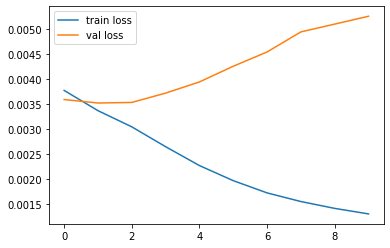

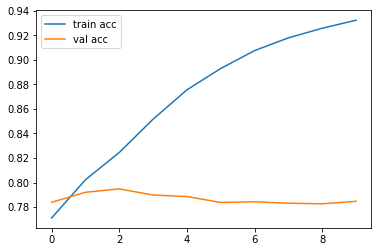

In [0]:
show_logs(logs)

In [0]:
# save model
# !cp ./best_bow.model ./drive/My\ Drive/hw4/

测试["today is a good day, but it is hot",
 "today is hot, but it is a good day" ]的预测结果。

In [0]:
!cp /content/drive/My\ Drive/hw4/best_bow.model ./

In [0]:
bow_model = torch.load('./best_bow.model')
# load data
train_data, train_label = load_data(data_path, 'training_label.txt')
test_data = load_data(data_path, 'testing_data.txt')
bow_preprocesser = PreprocesserBOW(train_data+test_data, 3000)

In [0]:
target_data = ["today is a good day, but it is hot",
 "today is hot, but it is a good day" ]
target_data = [t.split() for t in target_data]
test_x_bow = bow_preprocesser._to_bow(target_data)

bow model 处理["today is a good day, but it is hot", "today is hot, but it is a good day" ]结果如下。

In [0]:
bow_model.eval()
with torch.no_grad():
    input_ = torch.tensor(test_x_bow).to(device, dtype=torch.float)
    output_ = bow_model(input_)
    print(output_)

tensor([[0.5937],
        [0.5491]], device='cuda:0')


### 6.2.2  rnn model

下面使用示例代码中的模型，整理早先的代码，自己实现的performce差一点。

In [0]:
# model.py
# 這個 block 是要拿來訓練的模型
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix 住，如果 fix_embedding 為 False，在訓練過程中，embedding 也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        #                               input size             output size                 lstm layers num              
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout = 0.5, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, hidden_dim*2),
                                         nn.ReLU(),
                                         nn.Linear(hidden_dim*2, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] # lstm 返回的shape为 none，layer，output
        x = self.classifier(x)
        return x
    
class PreprocessserW2V():
    def __init__(self, w2v_path=None, emb_dim = 250):
        if w2v_path is None:
            print("Please call train_embedding")
            return
        w2v_model = Word2Vec.load(w2v_path)
        # map word to idx and idx to vector
        self.word2idx = {}
        idx2word = []
        embedding_matrix = []

        for word in w2v_model.wv.vocab:
            idx2word.append(word)
            self.word2idx[word] = len(idx2word)-1
            embedding_matrix.append(w2v_model[word])

        # add <PAD> and <UNK> 
        word  = '<PAD>'
        idx2word.append(word)
        self.word2idx[word] = len(idx2word)-1
        embedding_matrix.append(np.random.uniform(0,1,emb_dim))
        word  = '<UNK>'
        idx2word.append(word)
        self.word2idx[word] = len(idx2word)-1
        embedding_matrix.append(np.random.uniform(0,1,emb_dim))
        self. emb_matrix = np.zeros((len(embedding_matrix), emb_dim))
        for i in range(self.emb_matrix.shape[0]):
            self.emb_matrix[i, :] = embedding_matrix[i][:]
    
    def _get_emb_matrix(self):
        return self.emb_matrix

    def _to_w2v(self, data, label = None, len_sentence = 20):
        x = np.empty((len(data), len_sentence), dtype = np.int32)
        
        for i,sentence in enumerate(data):
                sen_len = len(sentence)
                for j in range(len_sentence):
                    if j >= sen_len:
                        x[i,j] = self.word2idx['<PAD>']
                        continue
                    word = sentence[j]
                    if word in self.word2idx.keys():
                        x[i,j] = self.word2idx[word]
                    else:
                        x[i,j] = self.word2idx['<UNK>']
        if label is not None:
            y = np.array(label).reshape(-1)
            return x, y
        else:
            return x


    def _train_embedding(self, data, dimension = 250, window = 5, min_count = 5, workers = 12, iter =10, sg = 10):
        self.w2v_model = word2vec.Word2Vec(data,
                          size = dimension,                                                                 # dimension
                          window = window,                                                              # windlow of context
                          min_count = min_count,                                                          # remove low frequency word
                          workers = workers,                                                            # precess tread 
                          iter = iter,                                                                   # iteration
                          sg = sg                                                                       #  if 1, use skp-gram, 0 use cbow
        )

        

In [0]:
w2v_preprocesser._to_w2v(test_data)
!cp ./drive/My\ Drive/hw4/w2v_all* ./

In [0]:
# load test
test_data = load_data(data_path, 'testing_data.txt')
# create preprocessor
w2v_path = os.path.join(data_path, 'w2v_all_without')
w2v_preprocesser = PreprocessserW2V(w2v_path)
# preprocess test data
test_x = w2v_preprocesser._to_w2v(test_data)
# load model
data_path = './'
rnn_model = torch.load(os.path.join(data_path, 'best_rnn.model'))

In [0]:
target_data = ["today is a good day, but it is hot",
 "today is hot, but it is a good day" ]
target_data = [t.split() for t in target_data]

In [0]:
test_x_rnn = w2v_preprocesser._to_w2v(target_data)

w2v模型对["today is a good day, but it is hot",
 "today is hot, but it is a good day" ]的预测如下。

In [0]:
rnn_model.eval()
with torch.no_grad():
    input_ = torch.tensor(test_x_rnn).to(device, dtype=torch.long)
    output_ = rnn_model(input_)
    print(output_)

tensor([[0.6308],
        [0.9297]], device='cuda:0')


### 6.2.3  结论

rnn + w2v模型表现如下：

> acc 80.937
>
> ["today is a good day, but it is hot", "today is hot, but it is a good day" ]
>   
> 0.6308概率为good， 0.9297概率为good

dnn + bow模型表现如下：

> acc 79.4800
>
> ["today is a good day, but it is hot", "today is hot, but it is a good day" ]
>   
> 0.5937概率为good，0.5491概率为good

从上面结果可以看出：
- 两个模型表现接近。
- 对于目标句子的识别，rnn+w2v显然正确的多。

我自己实现的模型还不如bow。这个有些意外，因为bow模型不考虑上下文，向量化方式比较简单。应该就是因为，对于情感分析，lstm其实并发挥不了太多的作用——想目标句子这种上下文自带否定的句子很少，通常来说我们看某个句子好坏（表达的感受）只需要从关键词“开心“，“wtf”，“sad”就可以大概率判断出来，这也是bow模型效果不错的原因。

再看对于目标句子的判别，bow模型显然搞错了，它以为第二句表达很好的感受，lstm模型就很好的handle这种情况。

## 6.3 实验分析与总结

这次调参上没有什么好说的，没跑过助教的示例代码，明明是同样原理的实现，不知道那部分出问题了，很郁闷。

心得如下：

- 边写边封装
- lstm的调参，唯一有点用的，就是stack lstm，dropout影响很小


## 6.4 Semi-supervised learning

这里首先实现最简单的self-learning的模型，为了更好的看到实验结果，按照提示，选择20000笔数据作为训练数据，10000笔作为val set，剩下的作为test set。大致流程：
- 获取新数据集，label 和 no label混合
- 训练，找到最佳模型，预测no label数据
- 回到第一步

In [0]:
class PreprocessserW2V():
    def __init__(self, w2v_path=None, emb_dim = 250):
        if w2v_path is None:
            print("Please call train_embedding")
            return
        w2v_model = Word2Vec.load(w2v_path)
        # map word to idx and idx to vector
        self.word2idx = {}
        idx2word = []
        embedding_matrix = []

        for word in w2v_model.wv.vocab:
            idx2word.append(word)
            self.word2idx[word] = len(idx2word)-1
            embedding_matrix.append(w2v_model[word])

        # add <PAD> and <UNK> 
        word  = '<PAD>'
        idx2word.append(word)
        self.word2idx[word] = len(idx2word)-1
        embedding_matrix.append(np.random.uniform(0,1,emb_dim))
        word  = '<UNK>'
        idx2word.append(word)
        self.word2idx[word] = len(idx2word)-1
        embedding_matrix.append(np.random.uniform(0,1,emb_dim))
        self. emb_matrix = np.zeros((len(embedding_matrix), emb_dim))
        for i in range(self.emb_matrix.shape[0]):
            self.emb_matrix[i, :] = embedding_matrix[i][:]
    
    def _get_emb_matrix(self):
        return self.emb_matrix

    def _to_w2v(self, data, label = None, len_sentence = 20):
        x = np.empty((len(data), len_sentence), dtype = np.int32)
        
        for i,sentence in enumerate(data):
                sen_len = len(sentence)
                for j in range(len_sentence):
                    if j >= sen_len:
                        x[i,j] = self.word2idx['<PAD>']
                        continue
                    word = sentence[j]
                    if word in self.word2idx.keys():
                        x[i,j] = self.word2idx[word]
                    else:
                        x[i,j] = self.word2idx['<UNK>']
        if label is not None:
            y = np.array(label).reshape(-1)
            return x, y
        else:
            return x


    def _train_embedding(self, data, dimension = 250, window = 5, min_count = 5, workers = 12, iter =10, sg = 10):
        self.w2v_model = word2vec.Word2Vec(data,
                          size = dimension,                                                                 # dimension
                          window = window,                                                              # windlow of context
                          min_count = min_count,                                                          # remove low frequency word
                          workers = workers,                                                            # precess tread 
                          iter = iter,                                                                   # iteration
                          sg = sg                                                                       #  if 1, use skp-gram, 0 use cbow
        )
    
def load_data(data_path, name):
    y = None
    # read
    with open(os.path.join(data_path, name)) as f:
        sentenses = f.readlines()
        if name == 'testing_data.txt':
            sentenses = sentenses[1:]
            sentenses = [sen.split(',',1)[1] for sen in sentenses]
        if name == 'training_label.txt':
            y = [int(sen[0]) for sen in sentenses]
            sentenses = [sen[10:] for sen in sentenses]
            
        sentences = [sen.strip('\n').split() for sen in sentenses]
    # deal with stopword and tense
    
    # def lemmatize(word):
    #     wnl = WordNetLemmatizer()
    #     word = wnl.lemmatize(word, 'n')
    #     word = wnl.lemmatize(word, 'v')
    #     word = wnl.lemmatize(word, 'a')
    #     return word

    x = []
    stopword = set(stopwords.words('english'))
    # # without stopword and lemmatize
    x = [sen.split() for sen in sentenses]
    # lemmatize
    # for sentence in sentences:
    #     x.append([lemmatize(word) for word in sentence])    

    # stopword  & lemmatize
    # for sentence in sentences:
    #     x.append([lemmatize(word) for word in sentence if word not in stopword])
    
    if y:
        return x,y
    else:
        return x

def split_data(data, label, split_radios):
    n = len(data)
    idx = np.arange(n)
    np.random.shuffle(idx)
    if len(split_radios) == 2:
        b1 = int(split_radios[0]/np.sum(split_radios) * n) 
        return data[idx[:b1]], label[idx[:b1]], data[idx[b1:]], label[idx[b1:]]
    elif len(split_radios)==3:
        b1 = int(split_radios[0]/np.sum(split_radios) * n) 
        b2 = int((split_radios[0]+ split_radios[1])/np.sum(split_radios) * n) 
        print(b1, b2)
        return data[idx[:b1]], label[idx[:b1]], data[idx[b1: b2]], label[idx[b1: b2]], data[idx[b2:]], label[idx[b2:]]

class lstm_model(nn.Module):
    def __init__(self, embedding_matrix, trainable_embedding = False):
        super(lstm_model,self).__init__()
        self.dim_emb =  embedding_matrix.shape[1]
        self.embedding = nn.Embedding(embedding_matrix.shape[0], self.dim_emb )
        self.embedding.weight = nn.Parameter(torch.Tensor(embedding_matrix))
        self.embedding.weight.requires_grad = trainable_embedding
        self.lstm_layers = nn.LSTM(self.dim_emb, 256, num_layers = 2, dropout = 0.5, batch_first = True)
        self.dnn = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(256, 1),
                        nn.Sigmoid()
        )
    def forward(self, x):
        out = self.embedding(x)
        out,_ = self.lstm_layers(out)
        out = out[:, -1, :] # 输出默认为sequence，使用最后一个time step的输出, (none，output_dim)，不需要再flatten
        return self.dnn(out)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    def __getitem__(self, i):
        # if self.y is not None:
        #     return torch.LongTensor(self.x[i, :]), torch.LongTensor(self.y[i])
        # return torch.LongTensor(self.x[i, :])
        if self.y is not None:
            return self.x[i, :], self.y[i]
        return self.x[i, :]
    def __len__(self):
        return len(self.x)
def training(model, train_loader, val_loader, device, num_epoch = 5, data_path = './',learning_rate = 0.001):
    def cal_acc(pred_b, y_b):
        output_b = pred_b.cpu().detach().numpy().reshape(-1)
        output_b[output_b>=0.5] = 1
        output_b[output_b < 0.5] = 0
        output_b = output_b.astype(np.int32)
        return np.sum(output_b == y_b.numpy())

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
    loss_func = nn.BCELoss()
    logs = {'time':[], 'train_loss':[], 'train_acc':[], 'val_acc':[], 'val_loss':[]}
    best_epochs = []
    best_acc = 0
    for epoch in range(num_epoch):
        time_epoch_start = time.time()
        train_acc = 0.0 
        train_loss = 0.0
        model.train()
        for i, (x_b, y_b) in enumerate(train_loader):
            # forward
            optimizer.zero_grad() 
            pred_b = model(x_b.to(device, dtype = torch.long)) # torch的特点，需要将数据设置到gpu上
            loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float))
            # backward
            loss_b.backward()
            optimizer.step()
            # log
            train_acc += cal_acc(pred_b, y_b)
            train_loss += loss_b.item()
    # calculate val acc and loss
        model.eval()
        val_acc = 0.0
        val_loss = 0.0
        with torch.no_grad():
            for i,(x_b, y_b) in enumerate(val_loader):
                pred_b = model(x_b.to(device, dtype = torch.long))
                loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float))
                val_acc += cal_acc(pred_b, y_b)
                val_loss += loss_b.item()
        # print log
        logs['time'].append(time.time()-time_epoch_start)
        logs['train_acc'].append(train_acc/train_set.__len__())
        logs['train_loss'].append(train_loss/train_set.__len__())
        logs['val_acc'].append(val_acc/val_set.__len__())
        logs['val_loss'].append(val_loss/val_set.__len__()) 
        # notes：打印logs
        # print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                (epoch + 1, num_epoch,  logs['time'][-1], \
                logs['train_acc'][-1] , logs['train_loss'][-1]*1000, logs['val_acc'][-1], logs['val_loss'][-1]*1000)) 
        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epochs.append(epoch)
            torch.save(model, os.path.join(data_path, 'best_semi.model'))
            print("Saving with acc : {}".format(logs['val_acc'][-1]))
    return logs

### 6.4.1  Self-learning

这个模型就是实现上述步骤的方法，简单而且直观。

In [0]:
!cp ./drive/My\ Drive/hw4/w2v_all* ./
data_path = './'
# create preprocessor
w2v_path = os.path.join(data_path, 'w2v_all_without')
w2v_preprocesser = PreprocessserW2V(w2v_path)
# load data
train_data, train_label = load_data(data_path, 'training_label.txt')
train_x, train_y = w2v_preprocesser._to_w2v(train_data, train_label)
# split data
train_x, train_y, val_x, val_y, test_x, test_y = split_data(train_x, train_y, [2, 1, 17])

20000 30000


In [0]:
train_x.shape

(2197, 20)

In [0]:
val_x.shape

(10989, 20)

In [0]:
test_x.shape

(186814, 20)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epoch = 10
batch_size = 128
low = 0.05
high = 0.95
log_acc = []
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
train_test_x, train_test_y = train_x, train_y

In [ ]:
for i in range(5):
    train_set,val_set, test_set = Dataset(train_test_x, train_test_y),Dataset(val_x, val_y), Dataset(test_x)
    train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = 8)
    val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                                batch_size = batch_size,
                                                shuffle = False,
                                                num_workers = 8)

    # model
    rnn_model = lstm_model(w2v_preprocesser._get_emb_matrix()).to(device)
    logs = training(rnn_model, train_loader, val_loader, device, num_epoch = num_epoch, data_path= data_path, learning_rate = learning_rate)
    # test
    model = torch.load(os.path.join(data_path, 'best_semi.model'))
    model.eval()
    test_pred = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            test_pred += outputs.tolist() 
    test_pred = np.array(test_pred)
    test_label = np.zeros(test_pred.shape, dtype =np.int8)
    test_label[test_pred>=0.5] = 1
    test_label[test_pred< 0.5] = 0
    log_acc.append(np.sum(test_label == test_y)/len(test_label))
    # Choose the data that predicts the best results
    add_x, add_y = test_x[(test_pred>high) | (test_pred < low)], test_label[(test_pred>high) | (test_pred < low)]
    print("------------------------------------------------")
    print("train size: {}".format(train_test_x.shape[0]))
    print("current acc: {}".format(log_acc[-1]))
    print("adding nolabel data,")
    print("- lable 1: {}".format(np.sum(add_y==1)))
    print("- lable 0: {}".format(np.sum(add_y==0)))
    print('-------------------------------------------------')
    # new dataset
    train_test_x, train_test_y = np.concatenate((train_x, add_x)),np.concatenate((train_y, add_y))

2000 笔训练数据，阈值0.1，0.9
````

[010/010] 1.15 sec(s) Train Acc: 0.776513 Loss: 3.956478 | Val Acc: 0.743198 loss: 4.180540
Saving with acc : 0.7431977431977432
------------------------------------------------
train size: 2197
current acc: 0.7428030019163446
adding nolabel data,
- lable 1: 11926
- lable 0: 39648
-------------------------------------------------
[007/010] 4.67 sec(s) Train Acc: 0.993156 Loss: 0.169375 | Val Acc: 0.753299 loss: 5.880286
Saving with acc : 0.7532987532987533
------------------------------------------------
train size: 53771
current acc: 0.7501472052415772
adding nolabel data,
- lable 1: 50298
- lable 0: 67212
-------------------------------------------------
[006/010] 8.83 sec(s) Train Acc: 0.996884 Loss: 0.098808 | Val Acc: 0.758213 loss: 9.933585
Saving with acc : 0.7582127582127582
------------------------------------------------
train size: 119707
current acc: 0.7533696618026486
adding nolabel data,
- lable 1: 83770
- lable 0: 87302
-------------------------------------------------
[003/010] 12.39 sec(s) Train Acc: 0.990293 Loss: 0.243880 | Val Acc: 0.759032 loss: 9.990977
Saving with acc : 0.759031759031759
------------------------------------------------
train size: 173269
current acc: 0.7551040071943216
adding nolabel data,
- lable 1: 85105
- lable 0: 88555
-------------------------------------------------
[009/010] 12.56 sec(s) Train Acc: 0.995593 Loss: 0.135653 | Val Acc: 0.759578 loss: 11.569117
Saving with acc : 0.7595777595777595
------------------------------------------------
train size: 175857
current acc: 0.7552967122378409
adding nolabel data,
- lable 1: 90647
- lable 0: 89291
-------------------------------------------------
[001/010] 13.09 sec(s) Train Acc: 0.941543 Loss: 1.036670 | Val Acc: 0.759669 loss: 9.814486
Saving with acc : 0.7596687596687597
------------------------------------------------
train size: 182135
current acc: 0.7561478261800507
adding nolabel data,
- lable 1: 85990
- lable 0: 86486
````

20000笔训练数据，阈值0.1，0.9

````
[007/010] 2.34 sec(s) Train Acc: 0.820600 Loss: 0.003122 | Val Acc: 0.787300 loss: 0.003761
Saving with acc : 0.7873
------------------------------------------------
train size: 20000
current acc: 0.7809823529411765
adding nolabel data,
- lable 1: 48917
- lable 0: 62929
-------------------------------------------------
[003/010] 9.63 sec(s) Train Acc: 0.970170 Loss: 0.000765 | Val Acc: 0.789600 loss: 0.004963
Saving with acc : 0.7896
------------------------------------------------
train size: 131846
current acc: 0.7816235294117647
adding nolabel data,
- lable 1: 64053
- lable 0: 74953
-------------------------------------------------
[008/010] 11.46 sec(s) Train Acc: 0.981994 Loss: 0.000544 | Val Acc: 0.790200 loss: 0.005861
Saving with acc : 0.7902
------------------------------------------------
train size: 159006
current acc: 0.7817
adding nolabel data,
- lable 1: 76039
- lable 0: 82730
-------------------------------------------------
[001/010] 12.80 sec(s) Train Acc: 0.909515 Loss: 0.001736 | Val Acc: 0.791300 loss: 0.005236
Saving with acc : 0.7913
------------------------------------------------
train size: 178769
current acc: 0.782035294117647
adding nolabel data,
- lable 1: 76408
- lable 0: 77083
-------------------------------------------------
[005/010] 12.35 sec(s) Train Acc: 0.977388 Loss: 0.000700 | Val Acc: 0.793300 loss: 0.005935
Saving with acc : 0.7933
------------------------------------------------
train size: 173491
current acc: 0.7831176470588235
adding nolabel data,
- lable 1: 80023
- lable 0: 82715
-------------------------------------------------

````


In [0]:
print(log_acc)

[0.7428030019163446, 0.7501472052415772, 0.7533696618026486, 0.7551040071943216, 0.7552967122378409, 0.7561478261800507, 0.7541351290588499, 0.7559658269722825, 0.7566884708854796, 0.7570096459580117]


#### 结论

上面是self-learning的实验日志，实验将train data分为3部分，2000笔作为训练数据（为了更好地看到模型提升，所以减少到2000笔），10000笔作为验证集用于early stop，180000笔作为测试集，模拟no label data。test部分的label可以计算准确率，不过只用于模型评价，不参与训练。

模型每次迭代选用预测概率大于0.9或小于0.1的数据假如训练集，迭代10次。

结果如下：

- 初始准确率74，模型经过10次迭代，准确率为75.7%，提升尚可
- 可以观察到一开始模型预测数据中，符合阈值的只有10000和30000，随着迭代，慢慢变多，第十次迭代选用接近90000和90000笔数据，这说明，模型预测结果越来越极端。
- 经过一次迭代，后面第一个epoch的train acc一开始就达到很高。这个现象可能是这样的，假如模型最终总是容易到达某种状态，而我用这种状态取预测，取出极端结果，加入训练集，那么模型再次到达接近该状态的时候，极端选择的数据符合“处于这个状态的模型”的预测，所以这时候对于这些极端数据，预测结果会和它们的伪标签很接近，因而此时准确率很高，loss很低。

结论：

self-training会记忆error，模型训练后预测的结果会存在某些error，一旦你把这些error加入训练集作为新模型的目标开始训练，则这种error会在每次迭代中传播。
所以结果不会提升非常大就是。

### 6.4.2 Entropy-based Regularization

$$E\left(y^{u}\right)=-\sum_{m=1}^{5} y_{m}^{u} \ln \left(y_{m}^{u}\right)$$

可视为正则项，它让模型输出结果尽可能极端。所以基本和上面的模型一模一样，只需要自定义损失函数即可。

**结论**

提升微乎其微。

In [0]:
class EBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.crossy = nn.BCELoss()
    def forward(self, y_hat, y, lambda_= 1):
        E = -torch.mean( y_hat * torch.log(y_hat) + (1 - y_hat) * torch.log(1 - y_hat))
        # print(E)
        #  不知道为什么，我这边自己写的binary crossy entropy 不行，结果是一样的。
        # return -torch.sum(y*torch.log(y_hat)+(1-y)*torch.log(1-y_hat)) + lambda_ * E
        return self.crossy(y_hat, y) + lambda_ * E

In [0]:
print(0.2*np.log(0.2)+0.8*np.log(0.8))
a = [0.2]
input = torch.Tensor(np.array(a))
target = torch.empty(1).random_(2)
m = nn.Sigmoid()
m(input)
print(nn.BCELoss()(input, target))
EBCELoss()(input, target, 0)

-0.5004024235381879
tensor(1.6094)


tensor(1.6094)

In [0]:
def e_training(model, train_loader, val_loader, device,num_epoch = 5,  lambda_ = 1,data_path = './',learning_rate = 0.001):
    def cal_acc(pred_b, y_b):
        output_b = pred_b.cpu().detach().numpy().reshape(-1)
        output_b[output_b>=0.5] = 1
        output_b[output_b < 0.5] = 0
        output_b = output_b.astype(np.int32)
        return np.sum(output_b == y_b.numpy())

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
    loss_func = EBCELoss()
    logs = {'time':[], 'train_loss':[], 'train_acc':[], 'val_acc':[], 'val_loss':[]}
    best_epochs = []
    best_acc = 0
    for epoch in range(num_epoch):
        time_epoch_start = time.time()
        train_acc = 0.0 
        train_loss = 0.0
        model.train()
        for i, (x_b, y_b) in enumerate(train_loader):
            # forward
            optimizer.zero_grad() 
            pred_b = model(x_b.to(device, dtype = torch.long)) # torch的特点，需要将数据设置到gpu上
            loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float), lambda_)
            # backward
            loss_b.backward()
            optimizer.step()
            # log
            train_acc += cal_acc(pred_b, y_b)
            train_loss += loss_b.item()
    # calculate val acc and loss
        model.eval()
        val_acc = 0.0
        val_loss = 0.0
        with torch.no_grad():
            for i,(x_b, y_b) in enumerate(val_loader):
                pred_b = model(x_b.to(device, dtype = torch.long))
                loss_b = loss_func(pred_b, y_b.to(device, dtype = torch.float), lambda_)
                val_acc += cal_acc(pred_b, y_b)
                val_loss += loss_b.item()
        # print log
        logs['time'].append(time.time()-time_epoch_start)
        logs['train_acc'].append(train_acc/train_set.__len__())
        logs['train_loss'].append(train_loss/train_set.__len__())
        logs['val_acc'].append(val_acc/val_set.__len__())
        logs['val_loss'].append(val_loss/val_set.__len__()) 
        # notes：打印logs
        # print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                (epoch + 1, num_epoch,  logs['time'][-1], \
                logs['train_acc'][-1] , logs['train_loss'][-1]*1000, logs['val_acc'][-1], logs['val_loss'][-1]*1000)) 
        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epochs.append(epoch)
            torch.save(model, os.path.join(data_path, 'best_semi.model'))
            print("Saving with acc : {}".format(logs['val_acc'][-1]))
    return logs

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
lambda_ = 0.3 # entropy rate
num_epoch = 10
batch_size = 128
low = 0.01
high = 0.99
log_acc = []
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
train_test_x, train_test_y = train_x, train_y

In [0]:
for i in range(10):
    train_set,val_set, test_set = Dataset(train_test_x, train_test_y),Dataset(val_x, val_y), Dataset(test_x)
    train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = 8)
    val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                                batch_size = batch_size,
                                                shuffle = False,
                                                num_workers = 8)

    # model
    rnn_model = lstm_model(w2v_preprocesser._get_emb_matrix()).to(device)
    logs = e_training(rnn_model, train_loader, val_loader, device, lambda_ = lambda_, num_epoch = num_epoch, data_path= data_path, learning_rate = learning_rate)
    # test
    model = torch.load(os.path.join(data_path, 'best_semi.model'))
    model.eval()
    test_pred = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            test_pred += outputs.tolist() 
    test_pred = np.array(test_pred)
    test_label = np.zeros(test_pred.shape, dtype =np.int8)
    test_label[test_pred>=0.5] = 1
    test_label[test_pred< 0.5] = 0
    log_acc.append(np.sum(test_label == test_y)/len(test_label))
    # Choose the data that predicts the best results
    add_x, add_y = test_x[(test_pred>high) | (test_pred < low)], test_label[(test_pred>high) | (test_pred < low)]
    print("------------------------------------------------")
    print("train size: {}".format(train_test_x.shape[0]))
    print("current acc: {}".format(log_acc[-1]))
    print("adding nolabel data,")
    print("- lable 1: {}".format(np.sum(add_y==1)))
    print("- lable 0: {}".format(np.sum(add_y==0)))
    print('-------------------------------------------------')
    # new dataset
    train_test_x, train_test_y = np.concatenate((train_x, add_x)),np.concatenate((train_y, add_y))

[001/010] 2.51 sec(s) Train Acc: 0.648200 Loss: 6.248311 | Val Acc: 0.732100 loss: 5.433541
Saving with acc : 0.7321
[002/010] 2.48 sec(s) Train Acc: 0.756600 Loss: 5.035489 | Val Acc: 0.770900 loss: 5.084585
Saving with acc : 0.7709
[003/010] 2.51 sec(s) Train Acc: 0.776800 Loss: 4.704654 | Val Acc: 0.771600 loss: 4.827197
Saving with acc : 0.7716
[004/010] 2.58 sec(s) Train Acc: 0.787650 Loss: 4.540770 | Val Acc: 0.772700 loss: 4.819413
Saving with acc : 0.7727
[005/010] 2.53 sec(s) Train Acc: 0.796650 Loss: 4.352282 | Val Acc: 0.782600 loss: 4.724758
Saving with acc : 0.7826
[006/010] 2.52 sec(s) Train Acc: 0.805500 Loss: 4.222201 | Val Acc: 0.776800 loss: 4.759089
[007/010] 2.51 sec(s) Train Acc: 0.817250 Loss: 3.989873 | Val Acc: 0.767900 loss: 5.013383
[008/010] 2.47 sec(s) Train Acc: 0.827650 Loss: 3.828512 | Val Acc: 0.780300 loss: 4.852379
[009/010] 2.47 sec(s) Train Acc: 0.846750 Loss: 3.474392 | Val Acc: 0.772700 loss: 5.089710
[010/010] 2.49 sec(s) Train Acc: 0.862650 Loss: